In [1]:
import sys
import numpy as np
from scipy import linalg
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)
s0 = np.loadtxt('s0_PF00186.txt').astype(int)

In [3]:
q = 21
theta=0.2
pseudo_weight=0.5

l,n = s0.shape
mx = np.full(n,q)

s0.shape

(6734, 133)

In [4]:
def frequency(s0,q):
    l,n = s0.shape
    
    # hamming distance
    dst = distance.squareform(distance.pdist(s0, 'hamming'))
    ma_inv = 1/(1+(dst < theta).sum(axis=1).astype(float))
    meff = ma_inv.sum()

    # fi_true:
    fi_true = np.zeros((n,q))
    for t in range(l):
        for i in range(n):
            fi_true[i,s0[t,i]] += ma_inv[t]

    fi_true /= meff

    # fij_true:
    fij_true = np.zeros((n,n,q,q))
    for t in range(l):
        for i in range(n-1):
            for j in range(i+1,n):
                fij_true[i,j,s0[t,i],s0[t,j]] += ma_inv[t]
                fij_true[j,i,s0[t,j],s0[t,i]] = fij_true[i,j,s0[t,i],s0[t,j]]

    fij_true /= meff  

    scra = np.eye(q)
    for i in range(n):
        for alpha in range(q):
            for beta in range(q):
                fij_true[i,i,alpha,beta] = fi_true[i,alpha]*scra[alpha,beta]     

    # fi, fij
    fi = (1 - pseudo_weight)*fi_true + pseudo_weight/q
    fij = (1 - pseudo_weight)*fij_true + pseudo_weight/(q**2)

    scra = np.eye(q)
    for i in range(n):
        for alpha in range(q):
            for beta in range(q):
                fij[i,i,alpha,beta] = (1 - pseudo_weight)*fij_true[i,i,alpha,beta]\
                                        + pseudo_weight/q*scra[alpha,beta] 

    return fi,fij            

In [5]:
# convert index from 4d to 2d
def mapkey(i,alpha,q):
    return i*(q-1) + alpha

In [6]:
def correlation(fi,fij,q):
    # compute correlation matrix:
    c = np.zeros((n*(q-1),n*(q-1)))
    for i in range(n):
        for j in range(n):
            for alpha in range(q-1):
                for beta in range(q-1):
                    c[mapkey(i,alpha,q),mapkey(j,beta,q)] = fij[i,j,alpha,beta] - fi[i,alpha]*fi[j,beta]
                    
    return c                

In [7]:
# set w = - c_inv
def interactions(c_inv,q):
    w = np.zeros((n,n,q,q))
    w2 = np.zeros((n*q,n*q))
    for i in range(n):
        for j in range(i+1,n):
            for alpha in range(q-1):
                for beta in range(q-1):
                    w[i,j,alpha,beta] = -c_inv[mapkey(i,alpha,q),mapkey(j,beta,q)]
                    w2[mapkey(i,alpha,q),mapkey(j,beta,q)] = -c_inv[mapkey(i,alpha,q),mapkey(j,beta,q)]
                    
    w2 = w2+w2.T
    return w,w2

In [8]:
# direct information
def direct_info(w,fi):
    
    ew_all = np.exp(w)
    di = np.zeros((n,n))
    tiny = 10**(-100.)
    diff_thres = 10**(-4.)

    for i in range(n-1):
        for j in range(i+1,n):        
            ew = ew_all[i,j,:,:]

            #------------------------------------------------------
            # find h1 and h2:

            # initial value
            diff = diff_thres + 1.
            eh1 = np.full(q,1./q)
            eh2 = np.full(q,1./q)

            fi0 = fi[i,:]
            fj0 = fi[j,:]

            for iloop in range(100):
                eh_ew1 = eh2.dot(ew.T)
                eh_ew2 = eh1.dot(ew)

                eh1_new = fi0/eh_ew1
                eh1_new /= eh1_new.sum()

                eh2_new = fj0/eh_ew2
                eh2_new /= eh2_new.sum()

                diff = max(np.max(np.abs(eh1_new - eh1)),np.max(np.abs(eh2_new - eh2)))

                eh1,eh2 = eh1_new,eh2_new    
                if diff < diff_thres: break        

            # direct information
            eh1eh2 = eh1[:,np.newaxis]*eh2[np.newaxis,:]
            pdir = ew*(eh1eh2)
            pdir /= pdir.sum() 

            fifj = fi0[:,np.newaxis]*fj0[np.newaxis,:]

            dijab = pdir*np.log((pdir+tiny)/(fifj+tiny))
            di[i,j] = dijab.sum()

    # symmetrize di
    di = di + di.T
    return di

In [9]:
fi,fij = frequency(s0,q)
c = correlation(fi,fij,q)
c_inv = linalg.inv(c)

w,w2d = interactions(c_inv,q)

#np.save('w.npy',w)  # 4d
#np.savetxt('w2d.dat',w2d,fmt='%f') # 2d

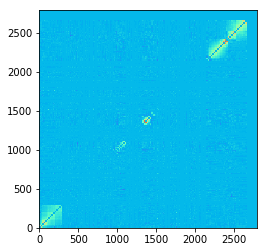

In [10]:
plt.imshow(w2d,cmap='rainbow',origin='lower')

In [11]:
di = direct_info(w,fi)
np.savetxt('di.dat',di,fmt='% f')

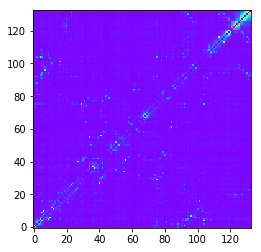

In [12]:
plt.imshow(di,cmap='rainbow',origin='lower')